In [ ]:
project_name = 'GAN_Anime_Faces_0'

In [ ]:
!pip install opendatasets --upgrade

In [ ]:
{"username":"sanhitarajput","key":"070852286b86e73cb11c64609ef77d2e"}

{'username': 'sanhitarajput', 'key': '070852286b86e73cb11c64609ef77d2e'}

In [ ]:
import opendatasets as od

dataset_url = 'https://www.kaggle.com/datasets/splcher/animefacedataset'
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: sanhitarajput
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/splcher/animefacedataset


In [ ]:
import os

data_directory = './animefacedataset'
print(os.listdir(data_directory))

['images']


In [ ]:
print(os.listdir(data_directory+'/images')[:10])

['29317_2010.jpg', '23394_2008.jpg', '23388_2008.jpg', '4792_2003.jpg', '54817_2016.jpg', '51757_2015.jpg', '62882_2019.jpg', '51230_2015.jpg', '36197_2011.jpg', '63250_2019.jpg']


In [ ]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

In [ ]:
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [ ]:
train_ds = ImageFolder(data_directory, transform=T.Compose([
     T.Resize(image_size),
     T.CenterCrop(image_size),
     T.ToTensor(),
     T.Normalize(*stats)]))

train_dl = DataLoader(train_ds,
                       batch_size,
                       shuffle=True,
                       num_workers=2,
                       pin_memory=True)

In [ ]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as  plt
%matplotlib inline

In [ ]:
def denorm(img_tensor):
  return img_tensor * stats[1][0] + stats[0][0]

In [ ]:
def show_images(images, nmax=64):
  fig, ax = plt.subplots(figsize = (8, 8))
  ax.set_xticks([]); ax.set_yticks([])
  ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
  for images, _ in dl:
    show_images(images, nmax)
    break


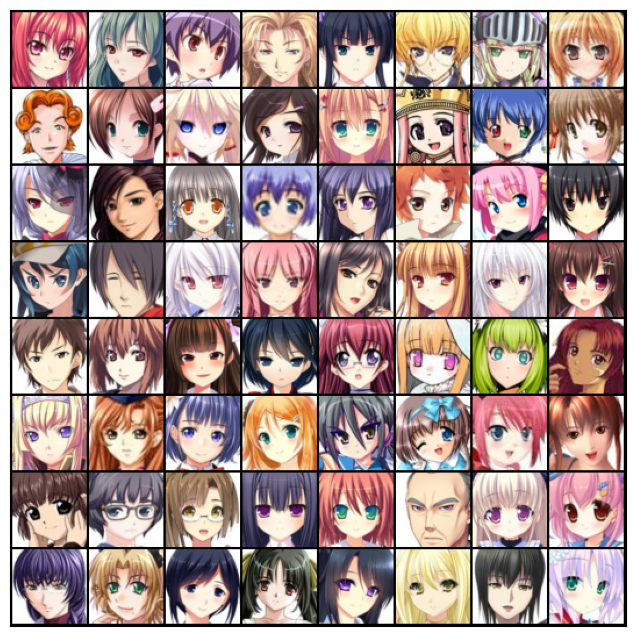

In [ ]:
show_batch(train_dl)

In [ ]:
def get_default_device():
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    return torch.device('cpu')

def to_device(data, device):
  if isinstance(data, (list,tuple)):
    return [to_device(x, device) for x in data]
  return data.to(device, non_blocking=True)

class DeviceDtaLoader():
  def __init__(self, dl, device):
    self.dl = dl
    self.device = device

  def __iter__(self):
    for b in self.dl:
      yield to_device(b, self.device)

  def __len__(self):
    return len(self.dl)

In [ ]:
device = get_default_device()
device

device(type='cpu')

In [ ]:
train_dl = DeviceDtaLoader(train_dl, device)

In [ ]:
import torch.nn as nn

In [ ]:
discriminator = nn.Sequential(

  #in : 3 x 64 x 64
  nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
  nn.BatchNorm2d(64),
  nn.LeakyReLU(0.2, inplace=True),
  #out : 64 x 32 x 32

  nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
  nn.BatchNorm2d(128),
  nn.LeakyReLU(0.2, inplace=True),
  #out : 128 x 16 x 16

  nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
  nn.BatchNorm2d(256),
  nn.LeakyReLU(0.2, inplace=True),

  #in : 3 x 64 x 64
  nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
  nn.BatchNorm2d(512),
  nn.LeakyReLU(0.2, inplace=True),
  #out : 64 x 32 x 32

  nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),

  nn.Flatten(),
  nn.Sigmoid()

)

In [ ]:
discriminator = to_device(discriminator, device)

In [ ]:
latent_size = 128

In [ ]:
generator = nn.Sequential(

  #in : latent_size x 1 x 1
  nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
  nn.BatchNorm2d(512),
  nn.ReLU(True),
  #out : 512 x 4 x 4

  nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
  nn.BatchNorm2d(256),
  nn.ReLU(True),
  #out : 256 x 8 x

  nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
  nn.BatchNorm2d(128),
  nn.ReLU(True),
  #out : 128 x 16 x 16

  nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
  nn.BatchNorm2d(64),
  nn.ReLU(True),
  #out : 64 x 32 x32

  nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
  nn.Tanh()
  #out : 3 x 64 x 64

)

torch.Size([128, 128, 1, 1])
torch.Size([128, 3, 64, 64])


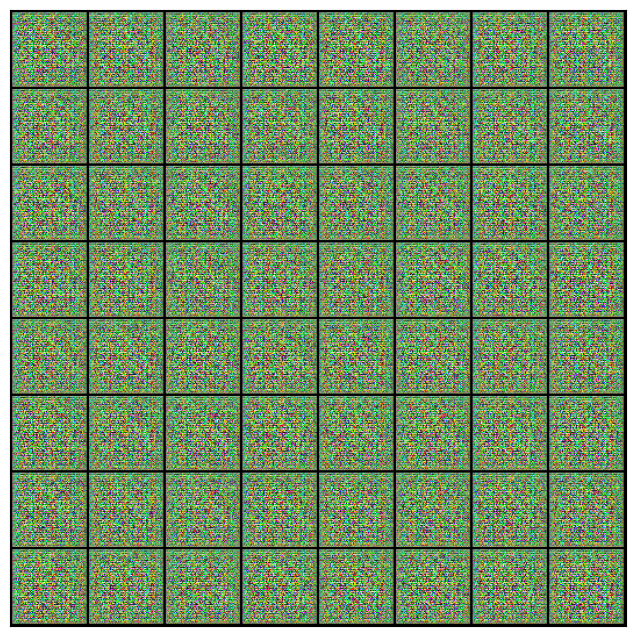

In [ ]:
xb = torch.rand(batch_size, latent_size, 1, 1)
print(xb.shape)
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [ ]:
generator = to_device(generator, device)

In [ ]:
def train_discriminator(real_images, opt_d):

  opt_d.zero_grad()

  real_preds = discriminator(real_images)
  real_targets = torch.ones(real_images.size(0), 1, device=device)
  real_loss = F.binary_cross_entropy(real_preds, real_targets)
  real_score = torch.mean(real_preds).item()

  latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
  fake_images = generator(latent)

  fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
  fake_preds = discriminator(fake_images)
  fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
  fake_score = torch.mean(fake_preds).item()

  loss = real_loss + fake_loss
  loss.backward()
  opt_d.step()
  return loss.item(), real_score, fake_score


In [ ]:
def train_generator(opt_g):
  opt_g.zero_grad()

  latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
  fake_images = generator(latent)

  preds = discriminator(fake_images)
  targets = torch.ones(batch_size, 1, device=device)
  loss = F.binary_cross_entropy(preds, targets)

  loss.backward()
  opt_g.step()

  return loss.item()

In [ ]:
from torchvision.utils import save_image

In [ ]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [ ]:
def save_samples (index, latent_tensors, show=True):
  fake_images = generator(latent_tensors)
  fake_fname = 'generated-images-{0:04d}.png'.format(index) # Corrected the format string
  save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
  print('Saving', fake_fname)
  if show:
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])  # Corrected to set empty ticks for y-axis
    ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [ ]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

Saving generated-images-0000.png


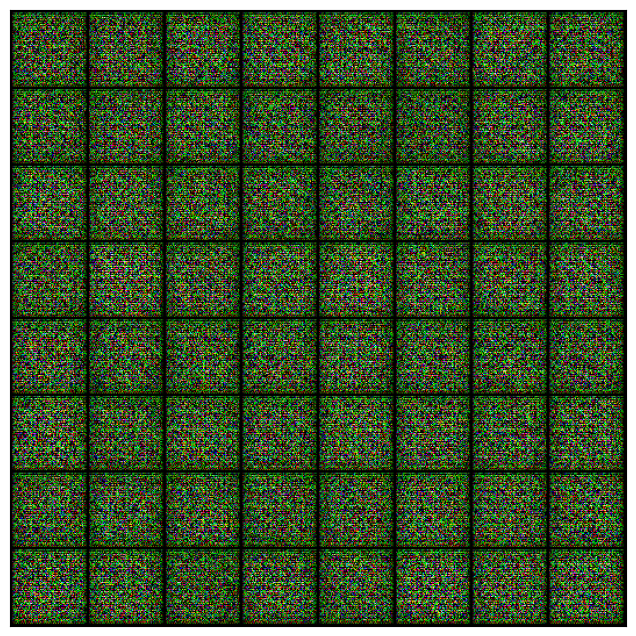

In [ ]:
save_samples(0, fixed_latent)

In [ ]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

In [ ]:
def fit(epochs, lr, start_idx=0):
    torch.cuda.empty_cache()

    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []

    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))

    for epoch in range(epochs):
      for real_images, _ in tqdm(train_dl):
        loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
        loss_g = train_generator(opt_g)
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)

    print("Epoch [{}/{}], loss_g: {:.4f), loss_d: {:.4f), real_score: {:.4f}, fake_".format(
        epoch + 1, epochs, loss_g, loss_d, real_score, fake_score))

    save_samples(epoch + start_idx, fixed_latent, show=False)

    return losses_g, losses_d, real_scores, fake_scores

In [ ]:
lr = 0.0002
epochs = 5

In [ ]:
history = fit(epochs, lr)

  0%|          | 0/497 [00:00<?, ?it/s]

In [ ]:
import cv2
import os

vid_fname = 'gans_training.avi'
files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]
files.sort()

out = cv2.VideoWriter(vid_fname, cv2.VideoWriter_fourcc(*'MP4V'), 1, (530, 530))
[out.write(cv2.imread(fname)) for fname in files]
out.release()
